In [1]:
import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {‘0’, ‘1’, ‘2’}
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"
#from tf_keras import layers, Model, models
from tensorflow.keras import layers, Model, models, metrics, optimizers
#from tensorflow import keras
import keras
import tensorflow_datasets as tfds
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import gc
import os
import json
tf.random.set_seed(1)

2024-11-03 13:38:28.537889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 13:38:28.721556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 13:38:28.773574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 13:38:29.118656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 13:38:31.389629: W tensorflow/compiler/tf2

TensorFlow version: 2.17.0
Num GPUs Available:  1


I0000 00:00:1730637514.928787   12190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730637515.410974   12190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730637515.411050   12190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Data loading + processing

In [6]:
full_geno_data = pd.read_csv("./data/ordered_geno_data.csv")
full_geno_np = full_geno_data.to_numpy()[:,2:]

In [3]:
geno_np_layers = [np.float16(full_geno_np == cur_class) for cur_class in [-1, 0, 1]]
geno_tensor = tf.stack(geno_np_layers, axis = 1)

I0000 00:00:1730474340.213139   72735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730474340.213256   72735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730474340.213301   72735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730474340.394588   72735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730474340.394727   72735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-01

In [4]:
geno_tensor = tf.random.shuffle(geno_tensor)
# train_dataset = geno_tensor[0:3788,...]
# train_dataset_in = geno_tensor[0:3788,...]
# test_dataset = geno_tensor[3788:,...]
# test_dataset_in = geno_tensor[3788:,...]
# true_classes = np.argmax(geno_tensor, axis = 1).reshape((-1))
# inv_class_frequencies = 1 - ((np.unique(true_classes, return_counts=True)[1] / len(true_classes)))
# inv_class_frequencies = inv_class_frequencies ** 1

In [6]:
full_dataset = tf.data.Dataset.from_tensor_slices((geno_tensor, geno_tensor))
full_dataset = full_dataset.shuffle(buffer_size=4689)
train_dataset = full_dataset.take(3500)
test_dataset = full_dataset.skip(3500)
train_dataset = train_dataset.batch(256, drop_remainder=True)
test_dataset = test_dataset.batch(256, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [7]:
test_samples = []
test_labels = []

for batch in test_dataset:
    # Each batch is a tuple of (features, labels)
    features, labels = batch
    test_samples.append(features.numpy())
    test_labels.append(labels.numpy())

# Convert list of arrays to a single NumPy array
import numpy as np

test_samples = np.concatenate(test_samples, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Convert NumPy arrays to tensors
test_samples_tensor = tf.convert_to_tensor(test_samples)
test_labels_tensor = tf.convert_to_tensor(test_labels)

2024-11-01 16:19:29.224080: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Layer tests

In [5]:
geno_ds = tf.data.Dataset.from_tensor_slices(geno_tensor)
geno_ds_b = geno_ds.batch(1)
cur_ds = next(geno_ds_b.as_numpy_iterator())
test_cnn = layers.Conv1D(filters=3, kernel_size=1, data_format="channels_first")
test_cnn(cur_ds)

2024-10-26 11:07:10.287220: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729933630.672179     940 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729933630.798854     940 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729933630.808668     940 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729933630.822374     940 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729933630.825457     940 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729933630.841429     940 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729933630.843298     940 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729933630.845038     940 gpu_t

<tf.Tensor: shape=(1, 3, 1144), dtype=float32, numpy=
array([[[-0.32819748,  0.44505048, -0.32819748, ...,  0.44505048,
         -0.32819748, -0.32819748],
        [-0.37148213,  0.38703394, -0.37148213, ...,  0.38703394,
         -0.37148213, -0.37148213],
        [ 0.27631664,  0.7428453 ,  0.27631664, ...,  0.7428453 ,
          0.27631664,  0.27631664]]], dtype=float32)>

### Autoencoder

In [11]:
fc_reg = keras.regularizers.L2(1e-10)
#l_relu = keras.activations.sigmoid()
class encoder(Model):
    def __init__(self, latent_dim, width = 1):
        super().__init__()
        self.latent_dim = latent_dim
        self.blocks = []
        for cur_block in range(width):
            self.blocks.append(
                [
                    layers.Dense(units=latent_dim, activation=None),
                    layers.LeakyReLU(negative_slope=0.5),
                    layers.Dense(units=latent_dim, activation=None),
                    layers.LeakyReLU(negative_slope=0.5)
                ]
            )
    def get_config(self):
        config = super().get_config() 
        config.update({
            'latent_dim': self.latent_dim,
            'blocks': [[keras.saving.serialize_keras_object(layer) for layer in block] for block in self.blocks]
        })
        return config

    @classmethod
    def from_config(cls, config):
        instance = cls(config['latent_dim'])
        
        # Deserialize each block's layers
        instance.blocks = []
        for block_config in config['blocks']:
            block_layers = []
            for layer_config in block_config:
                # Use the appropriate deserialization
                layer = keras.saving.deserialize_keras_object(layer_config)
                block_layers.append(layer)
            instance.blocks.append(block_layers)
        return instance

    def call(self, x):
        outputs = []
        x =  layers.Flatten()(x)
        for block in self.blocks:
            sub_x = x
            for layer in block:
                sub_x = layer(sub_x)
            outputs.append(sub_x)

        y = sum(outputs)

        return y


In [12]:
# Define the decoder model
fc_reg = keras.regularizers.L2(1e-5)
class decoder(Model):
    def __init__(self, latent_dim, depth = 1):
        super().__init__()
        self.latent_dim = latent_dim
        self.blocks = []
        for _ in range(3):
            # Create a block of layers
            block = []    
            # Add dense layers with Leaky ReLU activation after each
            for i in range(1, depth):
                block.append(layers.Dense(units=latent_dim * i))
                block.append(layers.LeakyReLU(negative_slope=0.5))
            # Add a final dense layer with fixed output units and kernel regularization
            block.append(layers.Dense(units=1144, kernel_regularizer=fc_reg))
            block.append(layers.LeakyReLU(negative_slope=0.5))  # Add Leaky ReLU after the final dense layer
            # Append the block to the blocks list
            self.blocks.append(block)

    def get_config(self):
        config = super().get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'blocks': [[keras.saving.serialize_keras_object(layer) for layer in block] for block in self.blocks]
        })
        return config
    

    @classmethod
    def from_config(cls, config):
        instance = cls(config['latent_dim'])
        
        # Deserialize each block's layers
        instance.blocks = []
        for block_config in config['blocks']:
            block_layers = []
            for layer_config in block_config:
                # Use the appropriate deserialization
                layer = keras.saving.deserialize_keras_object(layer_config)
                block_layers.append(layer)
            instance.blocks.append(block_layers)
        return instance

    
    def call(self, x):

        outputs = []
        for block in self.blocks:
            sub_x = x
            for layer in block:
                sub_x = layer(sub_x)
            sub_x = tf.reshape(sub_x, (-1, 1, 1144))
            outputs.append(sub_x)

        y = tf.concat(outputs, axis=-2)
        y = layers.Softmax(axis=1)(y)
        return y


In [13]:
# Define the autoencoder model
class autoencoder(Model):
    def __init__(self, latent_dim, encoder_width = 3, decoder_depth = 1):
        super().__init__()
        self.encoder = encoder(latent_dim, encoder_width)
        self.decoder = decoder(latent_dim, decoder_depth)

    def get_config(self):
        base_config = super().get_config()
        base_config.update({
            "latent_dim" : self.latent_dim,
            "encoder" : self.encoder,
            "decoder" : self.decoder
        })
        return base_config
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'latent_dim': self.encoder.latent_dim,
            'encoder': self.encoder.get_config(),
            'decoder': self.decoder.get_config()
        })
        return config

    @classmethod
    def from_config(cls, config):
        print("autoencoder config")
        latent_dim = config['latent_dim']
        instance = cls(latent_dim)
        print("calling encoder config")
        instance.encoder = encoder.from_config(config['encoder'])
        print("calling decoder config")
        instance.decoder = decoder.from_config(config['decoder'])
        print("finished loading config")
        return instance
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        #print(f"y shape:{x.shape}")
        return x

## Focal loss comparison:
* find easy classify examples
    * what probability disitribution do we strive for?
* Compute probability loss for easy examples, compare to probability increase for hard examples -> worth the tradeoff?
    * maintains ability to classify easy examples

#### Grid testing

In [21]:

def fit_per_para(encoder_w, decoder_d, epochs = 100):
    print("###########################################")
    print(f"encoder_w: {encoder_w}")
    print(f"decoder_d: {decoder_d}")
    true_classes = np.argmax(geno_tensor, axis = 1).reshape((-1))
    inv_class_frequencies = 1 - ((np.unique(true_classes, return_counts=True)[1] / len(true_classes)))
    inv_class_frequencies = inv_class_frequencies ** 1
    focal_loss = tf.keras.losses.CategoricalCrossentropy(axis = 1,
                                                          from_logits=False)
                                                          #alpha = np.array([0.02, 0.92, 0.05])[..., np.newaxis,],
                                                          #gamma=1)
    focal_optimizer = optimizers.Lion(learning_rate=1e-4, use_ema = True, gradient_accumulation_steps = 3)# ema_overwrite_frequency = int(1e3))
    model = autoencoder(200, encoder_width=encoder_w, decoder_depth=decoder_d)
    model.compile(optimizer=focal_optimizer, loss = focal_loss, run_eagerly=False,
                      metrics=[metrics.CategoricalAccuracy()])
    model_train_loss = model.fit(train_dataset, epochs=epochs, shuffle=True,
                                 validation_data = test_dataset)
    true_classes = np.argmax(test_labels, axis = 1).reshape((-1))
    pred_classes = np.argmax(model(test_labels), axis = 1).reshape((-1))
    class_acc = [np.sum((pred_classes == true_classes) & (pred_classes == cur_class))/
           np.sum(true_classes == cur_class) for cur_class in np.unique(true_classes)]
    print(class_acc)
    print(pd.crosstab(pd.Series(pred_classes, name="Predicted"), pd.Series(true_classes, name="Actual")))
    out = [class_acc, model_train_loss]
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()

    return out

In [22]:
paras = list(itertools.product(list(range(5,0,-1)),list(range(5,0, -1))))
#paras = list(itertools.product([5],list(range(1,5)))) + list(itertools.product(list(range(1,5)),[5])) + [(5,5)]
paras_l = list(itertools.product(list(range(10,5, -1)), list(range(10,0, -1)))) + list(itertools.product(list(range(5,0, -1)), list(range(10,5, -1))))

In [23]:
res_per_para = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 200) for cur_paras in paras]
#res_per_paral = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 200) for cur_paras in paras]

###########################################
encoder_w: 5
decoder_d: 5
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - categorical_accuracy: 0.0014 - loss: 1.1271 - val_categorical_accuracy: 0.0020 - val_loss: 1.0366
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0020 - loss: 1.0030 - val_categorical_accuracy: 6.5104e-04 - val_loss: 0.9019
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.0025 - loss: 0.8578 - val_categorical_accuracy: 0.0290 - val_loss: 0.7626
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.0299 - loss: 0.7604 - val_categorical_accuracy: 0.0280 - val_loss: 0.7459
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.0287 - loss: 0.7447 - val_categorical_accuracy: 0.0238 - val_loss: 0.7372
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0256 - loss: 0.7354 - val_categorical_accuracy: 0.0280 - val_loss: 0.7304
Epoch 7/200


In [26]:
res_dict = {str(paras[cur_para_id]):[res_per_para[cur_para_id][0], res_per_para[cur_para_id][1].history] for cur_para_id in range(len(paras))}
res_out = open("final_model_large_batch_nf_5.txt", "w")
res_out.write(json.dumps(res_dict))
res_out.close()

In [28]:
res_deep_encoder_thining = json.loads(open("./final_model_large_batch_nf_5.txt").read())
dt_keys = list(res_deep_encoder_thining.keys())
dt_acc = [res_deep_encoder_thining[cur_dict][0] for cur_dict in dt_keys]
dt_train = [res_deep_encoder_thining[cur_dict][1]["loss"] for cur_dict in dt_keys]
dt_val = [res_deep_encoder_thining[cur_dict][1]["val_loss"] for cur_dict in dt_keys]

In [29]:
dt_acc_df = pd.DataFrame(np.array(dt_acc))
dt_acc_df["fit"] = dt_keys

dt_train_df = pd.DataFrame(np.array(dt_train))
dt_train_df["fit"] = dt_keys

dt_train_df["loss_type"] = "train"
dt_val_df = pd.DataFrame(np.array(dt_val))
dt_val_df["fit"] = dt_keys
dt_val_df["loss_type"] = "test"
dt_train_df = pd.concat((dt_train_df, dt_val_df))

In [30]:
dt_train_df.to_csv("./data/final_model_large_batch_nf_5_train.csv", sep=",")
dt_acc_df.to_csv("./data/final_model_large_batch_nf_5_acc.csv", sep=",")

### Individual Models
# Its good enough, leave it

In [8]:
rec_focus_model = keras.models.load_model(
    "final_model_200.h5",
    custom_objects = {"encoder" : encoder, "decoder" : decoder, "autoencoder" : autoencoder}
)

autoencoder config
calling encoder config
calling decoder config


finished loading config


In [31]:
focal_loss = tf.keras.losses.CategoricalFocalCrossentropy(axis = 1,
                                                          from_logits=False, 
                                                          alpha = np.array([0.02, 0.92, 0.05])[..., np.newaxis,],
                                                          gamma=1)

focal_optimizer = optimizers.Lion(learning_rate=1e-4, use_ema = True, gradient_accumulation_steps = 3)# ema_overwrite_frequency = int(1e3))
focal_model = autoencoder(200, 5, 5)
focal_model.compile(optimizer=focal_optimizer, loss = focal_loss, run_eagerly=False,
                  metrics=[metrics.CategoricalAccuracy()])

In [32]:
model_train_loss = focal_model.fit(train_dataset, epochs=200, shuffle=True,
                                   validation_data = test_dataset)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - categorical_accuracy: 9.4436e-04 - loss: 0.0653 - val_categorical_accuracy: 3.2552e-04 - val_loss: 0.0638
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 1.5931e-04 - loss: 0.0634 - val_categorical_accuracy: 0.0000e+00 - val_loss: 0.0623
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 5.5425e-04 - loss: 0.0620 - val_categorical_accuracy: 6.5104e-04 - val_loss: 0.0606
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0023 - loss: 0.0608 - val_categorical_accuracy: 0.0023 - val_loss: 0.0603
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0047 - loss: 0.0597 - val_categorical_accuracy: 0.0039 - val_loss: 0.0589
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0036 - loss: 0.0586 - val_categorical_accuracy: 0.0072 - val_loss: 0.0577
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categori

In [34]:
true_classes = np.argmax(test_dataset_in, axis = 1).reshape((-1))
pred_classes = np.argmax(focal_model(test_dataset_in), axis = 1).reshape((-1))
class_acc = [np.sum((pred_classes == true_classes) & (pred_classes == cur_class))/
       np.sum(true_classes == cur_class) for cur_class in np.unique(true_classes)]

[0.9662975343492531, 1.0, 0.9856078763759241]
Actual          0      1       2
Predicted                       
0          639430      0    3905
1            2367  23002    1223
2           19935      0  351178
min val loss at epoch 199, with loss 0.00231124646961689


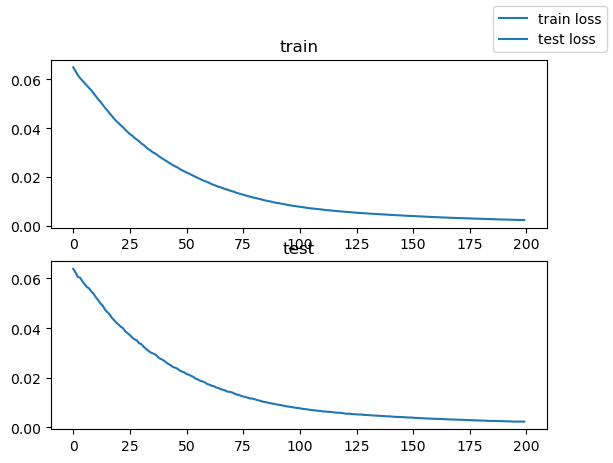

In [35]:
# less regulation -> less learning of c1?
true_classes = np.argmax(test_dataset_in, axis = 1).reshape((-1))
pred_classes = np.argmax(focal_model(test_dataset_in), axis = 1).reshape((-1))
class_acc = [np.sum((pred_classes == true_classes) & (pred_classes == cur_class))/
       np.sum(true_classes == cur_class) for cur_class in np.unique(true_classes)]
#acc_tracker.append(class_acc)
print(class_acc)
#print(np.array(acc_tracker))
print(pd.crosstab(pd.Series(pred_classes, name="Predicted"), pd.Series(true_classes, name="Actual")))
print(f"min val loss at epoch {np.argmin(model_train_loss.history["val_loss"])}, with loss {np.min(model_train_loss.history["val_loss"])}")
fig, ax = plt.subplots(2, 1)
x = list(range(len(model_train_loss.history["loss"][:])))
ax[0].plot(x, model_train_loss.history["loss"][:], label = "train loss")
ax[0].set_title("train")
ax[1].plot(x, model_train_loss.history["val_loss"][:], label = "test loss")
ax[1].set_title("test")
fig.legend()

In [23]:
focal_model.save("final_model_200.h5")

In [9]:
final_encoder = rec_focus_model.encoder

In [28]:
encoded_data = final_encoder(geno_tensor)

In [29]:
encoded_data_df = pd.DataFrame(encoded_data.numpy())
encoded_data_df["individual"] = full_geno_data["individual"]
encoded_data_df["pop"] = full_geno_data["pop"]
encoded_data_df.to_csv("encoded_genos.csv")

In [30]:
decoded_data = rec_focus_model.decoder(encoded_data)

In [31]:
full_geno_data

,X,individual,pop,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,...,PZA02474.1,PZA02528.1,PZA02862.3,PZA02984.10,PZA03036.6,PZA03048.18,PZA03317.1,PZA03578.1,PZA03603.1,PZB01944.1
0,0,1,13,0,0,0,0,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,1,2,13,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,1,-1,-1,-1,-1,-1,-1
2,2,3,13,1,1,1,1,1,1,1,...,1,1,1,1,-1,-1,-1,1,-1,-1
3,3,4,13,-1,-1,-1,-1,-1,-1,-1,...,1,-1,1,-1,-1,1,-1,1,-1,1
4,4,5,13,1,1,1,1,1,1,1,...,1,1,-1,-1,-1,1,1,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,188,196,12,-1,1,-1,1,1,1,1,...,1,1,1,-1,-1,1,1,-1,-1,-1
4694,189,197,12,-1,-1,-1,1,1,1,1,...,1,1,1,1,-1,1,1,-1,-1,-1
4695,190,198,12,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,-1,-1,1,-1,-1,-1
4696,191,199,12,-1,1,-1,1,1,1,1,...,-1,1,1,-1,-1,-1,-1,-1,-1,-1


In [35]:
np.argmax(decoded_data.numpy(), axis = 1)

array([[1, 1, 1, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [2, 2, 2, ..., 2, 0, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
# [-1, 0, 1]
decoded_data = rec_focus_model.decoder(encoded_data)
decoded_data_df = pd.DataFrame(np.argmax(decoded_data.numpy(), axis = 1))
decoded_data_df.replace([0, 1, 2], [-1, 0, 1], inplace=True)
decoded_data_df["individual"] = full_geno_data["individual"]
decoded_data_df["pop"] = full_geno_data["pop"]
decoded_data_df.to_csv("decoded_genos.csv")

In [150]:
pred_classes = np.argmax(rec_focus_model(geno_tensor), axis = 1)
true_classes = np.argmax(geno_tensor, axis = 1)
marker_acc = np.apply_over_axes(np.sum, pred_classes == true_classes, axes = 0)/pred_classes.shape[0]
marker_var = np.apply_over_axes(np.var, pred_classes == true_classes, axes = 0)/pred_classes.shape[0]

In [151]:
pd.DataFrame(pred_classes).to_csv("final_model_full_pred.csv")
pd.DataFrame(np.argmax(geno_tensor, axis = 1)).to_csv("full_dataset_truth.csv")


In [146]:
y = np.vstack([marker_acc[0][np.argsort(marker_acc[0])], marker_var[0][np.argsort(marker_acc[0])]])
x = range(y.shape[1])

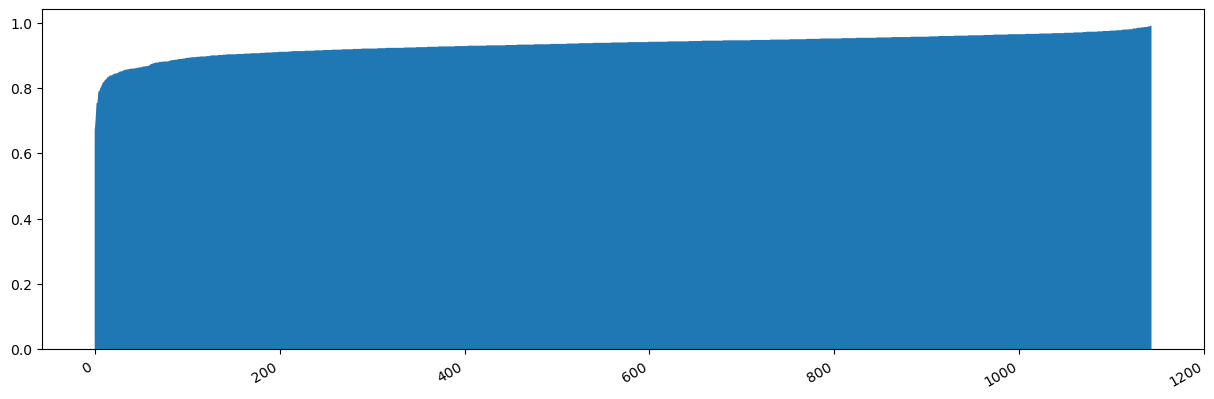

In [147]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
ax.stackplot(x, y)
#ax.tick_params(axis="x", rotation=90)
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
plt.rcParams['figure.figsize'] = [8, 5]

## Deprecated

In [ ]:
true_classes = np.argmax(geno_tensor, axis = 1).reshape((-1))
inv_class_frequencies = 1 - ((np.unique(true_classes, return_counts=True)[1] / len(true_classes)))
inv_class_frequencies = inv_class_frequencies ** 1
focal_loss = tf.keras.losses.CategoricalFocalCrossentropy(axis = 1,
                                                          from_logits=False, 
                                                          alpha = inv_class_frequencies[..., np.newaxis,],
                                                          gamma=8)

focal_optimizer = optimizers.Adam(learning_rate=1e-4)
focal_model = autoencoder(300)
focal_model.compile(optimizer=focal_optimizer, loss = focal_loss, run_eagerly=False,
                  metrics=[metrics.CategoricalAccuracy()])
cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
cosine_optimizer = optimizers.Adam(learning_rate=1e-4)
cosine_model = autoencoder(300)
cosine_model.compile(optimizer=cosine_optimizer, loss = focal_loss, run_eagerly=False,
                  metrics=[metrics.CategoricalAccuracy()])
acc_tracker = []